In [1]:
# importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pyarrow
import fastparquet
from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

In [ ]:
# OLD DATA IMPORT

# # importing our data
# # load the training data
# client_train = pd.read_csv('data/client_train.csv', low_memory=False)
# invoice_train = pd.read_csv('data/invoice_train.csv', low_memory=False)
# # load the testing data
# client_test = pd.read_csv('data/client_test.csv', low_memory=False)
# invoice_test = pd.read_csv('data/invoice_test.csv', low_memory=False)

# #concatenate to one df
# df_train = pd.merge(client_train, invoice_train, how='left', on='client_id')
# df_test = pd.merge(client_test, invoice_test, how='left', on='client_id')

In [2]:
# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_non_agg.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

# Import clean data
# - Each row represents one client. 
# - Invoices are summarized. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [3]:
# Alias
train = df_train_non_agg
test_final = df_final_test_non_agg
train_agg = df_train_agg
test_final_agg = df_final_test_agg

In [7]:
train.isna().sum().sum()

0

# Non-Aggregated data

In [4]:
# Extracting the target:

y = train.pop('target')

In [5]:
# Train-Test-Split
# 20% examples in test data
X_train, X_test, y_train, y_test = train_test_split(train,
                                         y, 
                                         stratify = y,
                                         test_size = 0.2, 
                                         random_state = 42)
# Features for feature importance
features = list(X_train.columns)

In [6]:
# Create the model with 100 trees
model = RandomForestClassifier(
                               class_weight="balanced",
                               n_estimators=50, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 5,
                               max_depth = 10,
                               min_samples_leaf = 5,
                               )

# Fit on training data
model.fit(X_train, y_train)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50building tree 10 of 50

building tree 11 of 50


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.5s


building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:  1.2min remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


Average number of nodes 738
Average maximum depth 10


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:    3.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | ela

Recall Baseline: 1.0 Test: 0.66 Train: 0.66
Precision Baseline: 0.08 Test: 0.13 Train: 0.13
Roc Baseline: 0.5 Test: 0.68 Train: 0.68
Confusion matrix, without normalization
[[494105 321784]
 [ 23858  46411]]


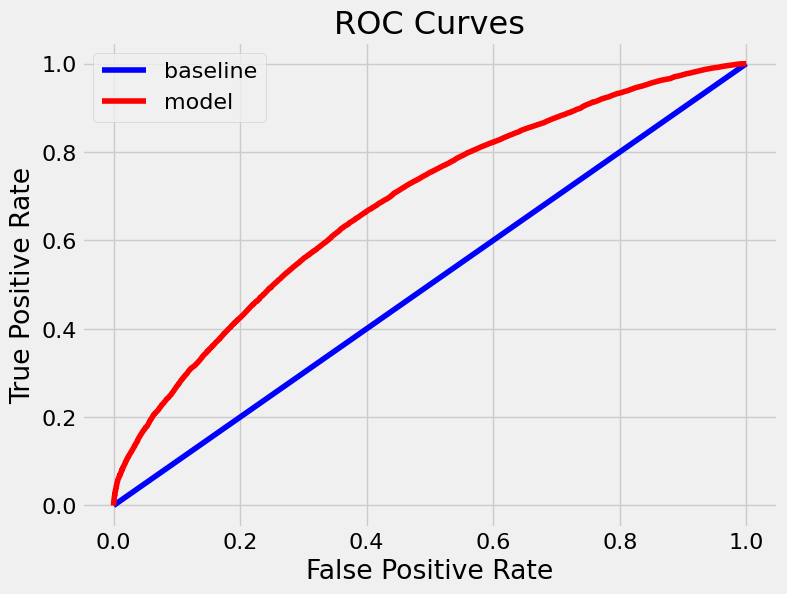

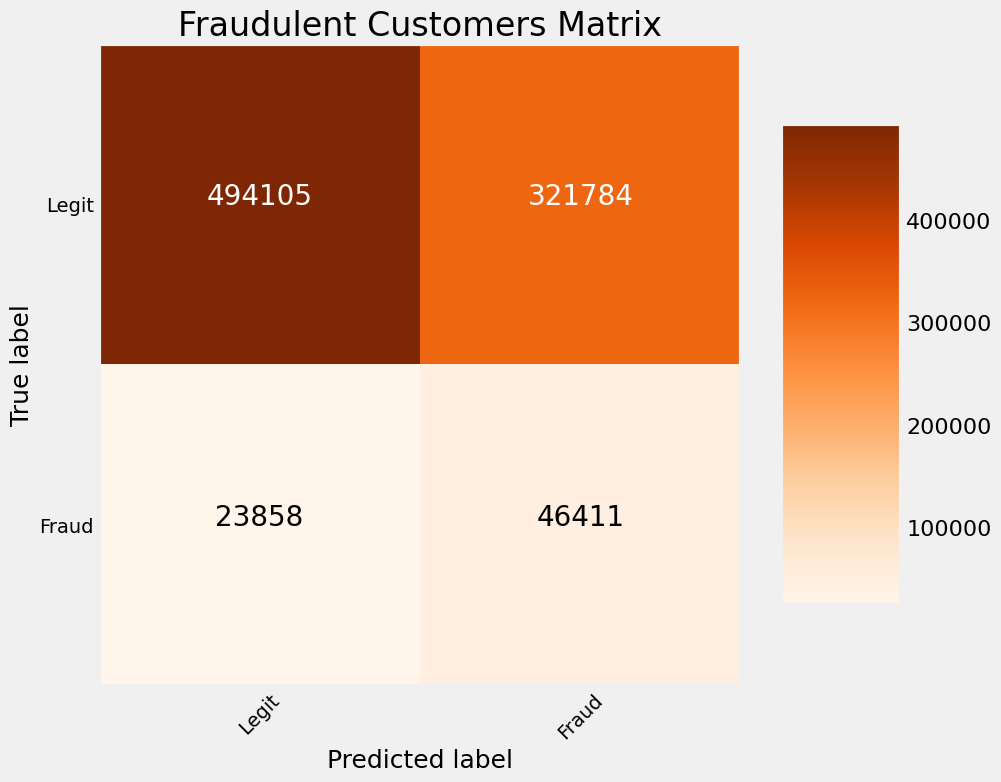

In [7]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    # plt.show();
    plt.savefig('data/rf_roc_auc_curve.png')

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)



from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
    plt.savefig('data/rf1_cm.png')

# Confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')


# Random forest with aggregated data

In [8]:
y_agg = train_agg.pop('target')

In [9]:
# Train-Test-Split
# 20% examples in test data
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(train_agg,
                                         y_agg, 
                                         stratify = y_agg,
                                         test_size = 0.2, 
                                         random_state = 42)
# Features for feature importance
features = list(X_train.columns)

In [10]:
# Create the model with 100 trees
model_agg = RandomForestClassifier(
                               class_weight="balanced",
                               n_estimators=50, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 5,
                               max_depth = 10,
                               min_samples_leaf = 5,
                               )

# Fit on training data
model_agg.fit(X_train_agg, y_train_agg)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree_agg in model_agg.estimators_:
    n_nodes.append(ind_tree_agg.tree_.node_count)
    max_depths.append(ind_tree_agg.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions_agg = model_agg.predict(X_train_agg)
train_rf_probs_agg = model_agg.predict_proba(X_train_agg)[:, 1]

# Testing predictions (to determine performance)
rf_predictions_agg = model_agg.predict(X_test_agg)
rf_probs_agg = model_agg.predict_proba(X_test_agg)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | e

Recall Baseline: 1.0 Test: 0.69 Train: 0.75
Precision Baseline: 0.06 Test: 0.12 Train: 0.13
Roc Baseline: 0.5 Test: 0.75 Train: 0.79
Confusion matrix, without normalization
[[16344  7744]
 [  473  1039]]


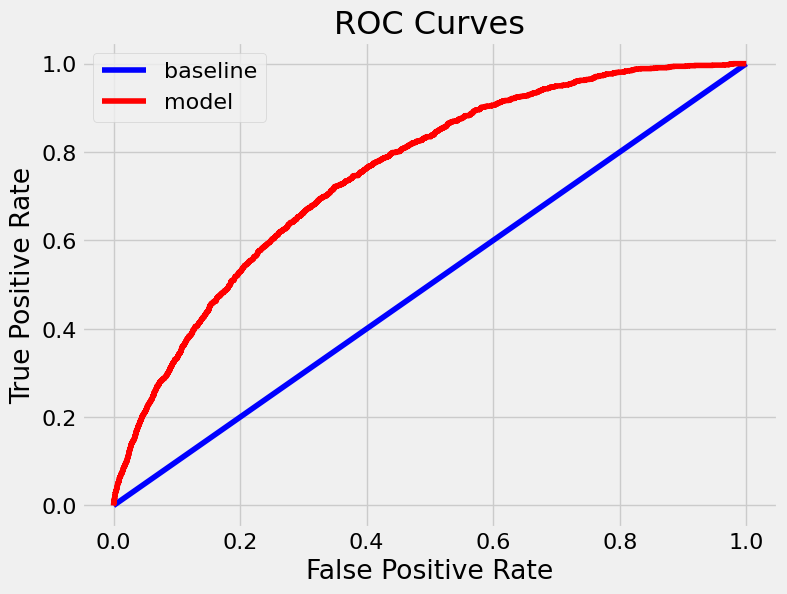

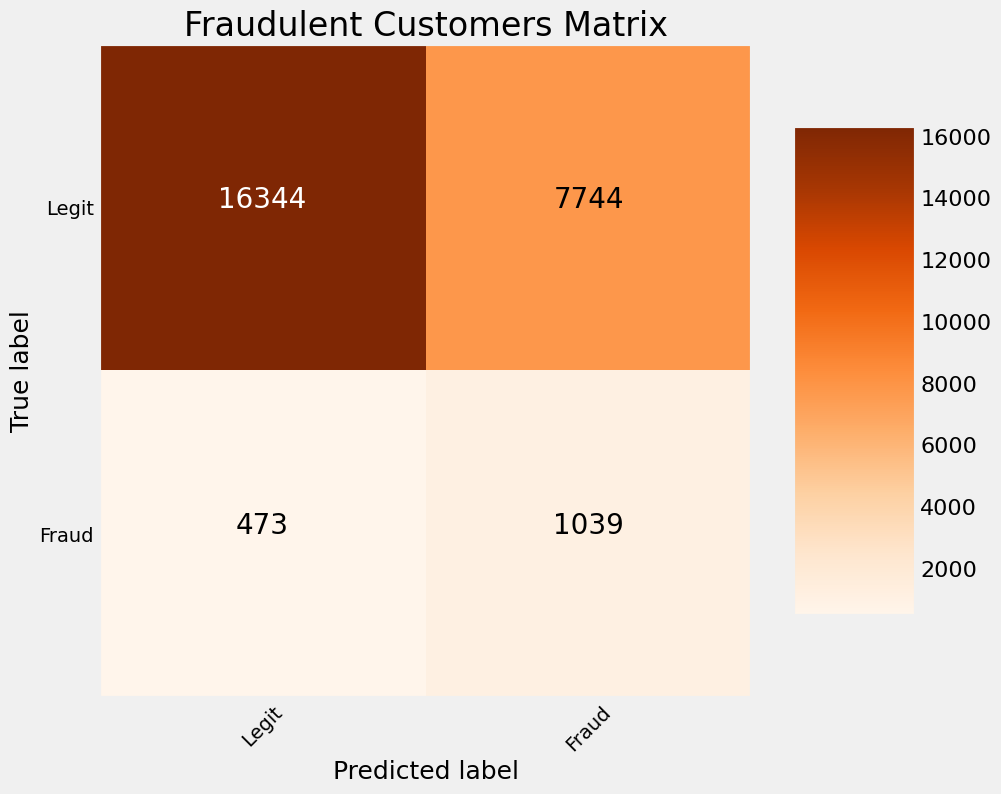

In [11]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test_agg, 
                                     [1 for _ in range(len(y_test_agg))])
    baseline['precision'] = precision_score(y_test_agg, 
                                      [1 for _ in range(len(y_test_agg))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test_agg, predictions)
    results['precision'] = precision_score(y_test_agg, predictions)
    results['roc'] = roc_auc_score(y_test_agg, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train_agg, train_predictions)
    train_results['precision'] = precision_score(y_train_agg, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_agg, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test_agg, [1 for _ in range(len(y_test_agg))])
    model_fpr, model_tpr, _ = roc_curve(y_test_agg, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    # plt.show();
    plt.savefig('data/rf_roc_auc_curve.png')

evaluate_model(rf_predictions_agg, rf_probs_agg, train_rf_predictions_agg, train_rf_probs_agg)



from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
    plt.savefig('data/rf1_cm.png')

# Confusion matrix
cm = confusion_matrix(y_test_agg, rf_predictions_agg)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')


In [13]:
print(classification_report(y_test_agg, rf_predictions_agg))

              precision    recall  f1-score   support

           0       0.97      0.68      0.80     24088
           1       0.12      0.69      0.20      1512

    accuracy                           0.68     25600
   macro avg       0.55      0.68      0.50     25600
weighted avg       0.92      0.68      0.76     25600



# Aggregated data with random search CV

In [14]:
# Import clean data aggregated
df_train_agg = pd.read_parquet("data/df_train_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [15]:
# Alias
train_agg = df_train_agg
test_final_agg = df_final_test_agg

In [16]:
# Extracting the target:
y_agg = train_agg.pop('target')

# Train-Test-Split
# 20% examples in test data
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(train_agg,
                                         y_agg, 
                                         stratify = y_agg,
                                         test_size = 0.2, 
                                         random_state = 42)
# Features for feature importance
features = list(X_train.columns)

In [17]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.arange(10, 201).astype(int),
    'max_depth': [None] + list(np.arange(2, 21).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 5, 0.1)),
    'max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
model_agg_rs = RandomForestClassifier(random_state = 42, class_weight="balanced")

# Create the random search model
rs = RandomizedSearchCV(model_agg_rs, param_grid, n_jobs = -1, 
                        scoring = 'f1', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=42)

# Fit 
rs.fit(X_train_agg, y_train_agg)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END bootstrap=True, max_depth=12, max_features=2.6999999999999993, max_leaf_nodes=20, min_samples_split=5, n_estimators=110;, score=nan total time=   0.1s[CV 3/3] END bootstrap=True, max_depth=12, max_features=2.6999999999999993, max_leaf_nodes=20, min_samples_split=5, n_estimators=110;, score=nan total time=   0.1s

[CV 2/3] END bootstrap=True, max_depth=12, max_features=2.6999999999999993, max_leaf_nodes=20, min_samples_split=5, n_estimators=110;, score=nan total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=11, max_features=4.899999999999999, max_leaf_nodes=13, min_samples_split=10, n_estimators=115;, score=nan total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=19, max_features=1.2999999999999998, max_leaf_nodes=50, min_samples_split=10, n_estimators=173;, score=nan total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=11, max_features=4.899999999999999, max_leaf_nodes=13, min_samples_split=10, 

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999,
                                                         0.9999999999999999,
                                                         1.0999999999999999,
                                                         1.199...
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200])},
                   random_state=42, scoring='f1', verbose=5)

In [18]:

rs.best_params_

{'n_estimators': 42,
 'min_samples_split': 5,
 'max_leaf_nodes': 48,
 'max_features': 0.7999999999999999,
 'max_depth': 4,
 'bootstrap': False}

In [19]:
best_model = rs.best_estimator_

In [20]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 31
Average maximum depth 4


In [27]:
train_rf_predictions = best_model.predict(X_train_agg)
train_rf_probs = best_model.predict_proba(X_train_agg)[:, 1]

rf_predictions = best_model.predict(X_test_agg)
rf_probs = best_model.predict_proba(X_test_agg)[:, 1]

Recall Baseline: 1.0 Test: 0.68 Train: 0.71
Precision Baseline: 0.06 Test: 0.1 Train: 0.1
Roc Baseline: 0.5 Test: 0.71 Train: 0.73
Confusion matrix, without normalization
[[14812  9276]
 [  478  1034]]


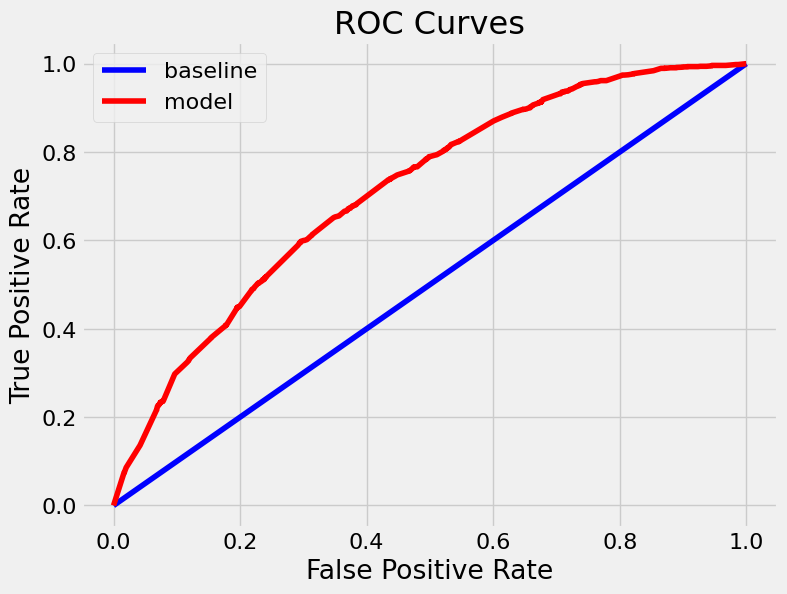

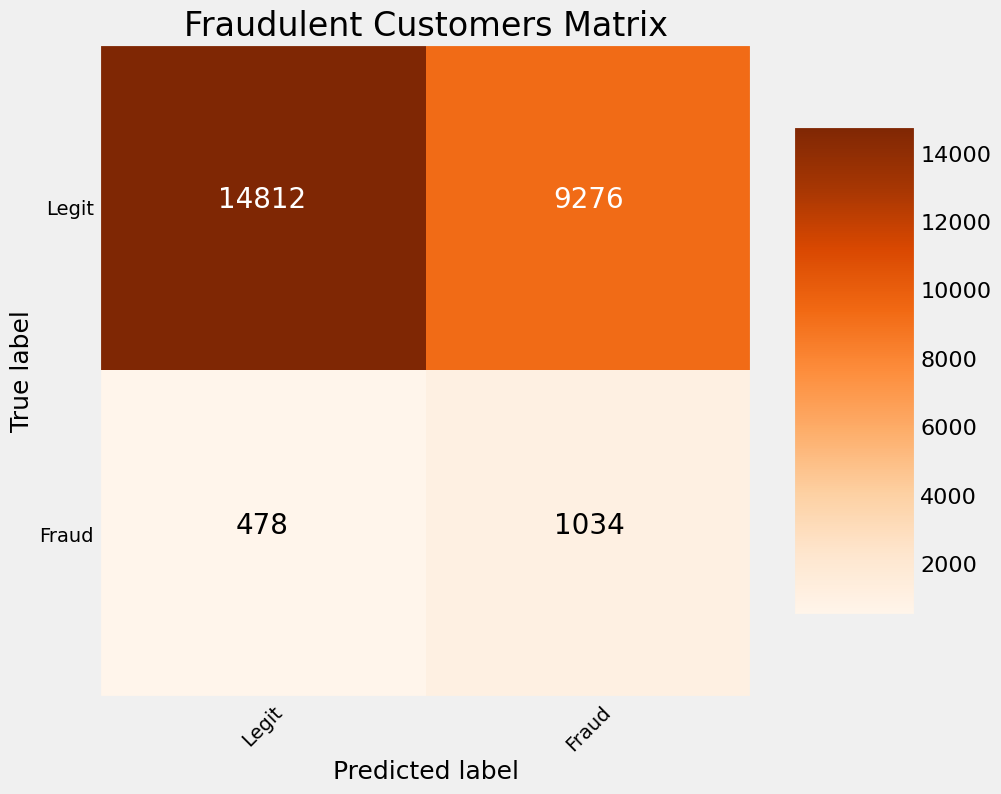

In [33]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test_agg, 
                                     [1 for _ in range(len(y_test_agg))])
    baseline['precision'] = precision_score(y_test_agg, 
                                      [1 for _ in range(len(y_test_agg))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test_agg, predictions)
    results['precision'] = precision_score(y_test_agg, predictions)
    results['roc'] = roc_auc_score(y_test_agg, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train_agg, train_predictions)
    train_results['precision'] = precision_score(y_train_agg, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_agg, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test_agg, [1 for _ in range(len(y_test_agg))])
    model_fpr, model_tpr, _ = roc_curve(y_test_agg, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    # plt.show();
    plt.savefig('data/rf_roc_auc_curve.png')

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)



from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
    plt.savefig('data/rf1_cm.png')

# Confusion matrix
cm = confusion_matrix(y_test_agg, rf_predictions)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')


In [34]:
print(classification_report(y_test_agg, rf_predictions))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75     24088
           1       0.10      0.68      0.17      1512

    accuracy                           0.62     25600
   macro avg       0.53      0.65      0.46     25600
weighted avg       0.92      0.62      0.72     25600



In [ ]:
fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(best_model.estimators_[0], filled=True)

In [ ]:
# Create the model with 100 trees
model = RandomForestClassifier(
                               class_weight="balanced",
                               n_estimators=50, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 5,
                               max_depth = 10,
                               min_samples_leaf = 5,
                               )

# Fit on training data
model.fit(X_train, y_train)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    # plt.show();
    plt.savefig('data/rf_roc_auc_curve.png')

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)



from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
    plt.savefig('data/rf1_cm.png')

# Confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')